In [20]:
import os

from descartes.patch import PolygonPatch
import joblib
import geopandas as gpd
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
d6_bbls = np.load("data/bimg_labels_d6.npy")
d9_bbls = np.load("data/bimg_labels_d9.npy")
pluto = gpd.read_file("data/pluto/MNMapPLUTO.shp")

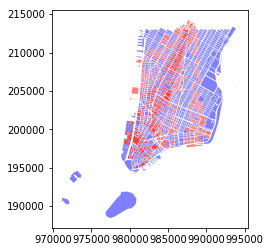

In [3]:
ax = pluto[(pluto.geometry.centroid.y < 213000) &\
           (~pluto.BBL.isin(np.unique(d6_bbls.ravel()))) &\
           (~pluto.BBL.isin(np.unique(d9_bbls.ravel())))].plot(color='blue', alpha=.5)
pluto[pluto.BBL.isin(np.unique(d6_bbls.ravel()))].plot(color='red', alpha=.5, ax=ax)
pluto[pluto.BBL.isin(np.unique(d9_bbls.ravel()))].plot(color='red', alpha=.5, ax=ax)

In [4]:
pluto["surface_area"] = pluto["NumFloors"] * pluto.geometry.length
in_frame = pluto[(pluto.BBL.isin(np.unique(d6_bbls.ravel()))) | pluto.BBL.isin(np.unique(d9_bbls.ravel()))]
out_frame = pluto[(pluto.geometry.centroid.y < 215000) & ~pluto.index.isin(in_frame.index)]

In [5]:
import os
if os.path.exists("data/impute_dists_centroid.gz"):
    dists = joblib.load("data/impute_dists_centroid.gz")
    nearest_idxs = joblib.load("data/impute_idxs_centroid.gz")
else:
    dists = []
    nearest_idxs = []
    for ix, building in out_frame.iterrows():
        if ix % 1000 == 0:
            print("at", ix)
        ds = in_frame.geometry.centroid.distance(building.geometry.centroid)
        dists.append(ds.min())
        nearest_idxs.append(ds.idxmin())
    joblib.dump(dists, "data/impute_dists_centroid.gz", 3)
    joblib.dump(nearest_idxs, "data/impute_idxs_centroid.gz", 3)

< 1000: 0.8288671903678144
< 500: 0.7271859628514793
== 0: 0.0


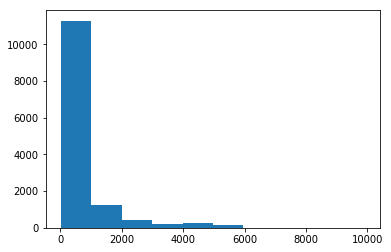

In [6]:
dists_arr = np.array(dists)
plt.hist(dists_arr)
print("< 1000: {}\n< 500: {}\n== 0: {}".format((dists_arr < 1000).sum() / len(dists_arr), 
      (dists_arr < 500).sum() / len(dists_arr),
      (dists_arr == 0).sum() / len(dists_arr)))

Text(0.5,1,'< 1000m')

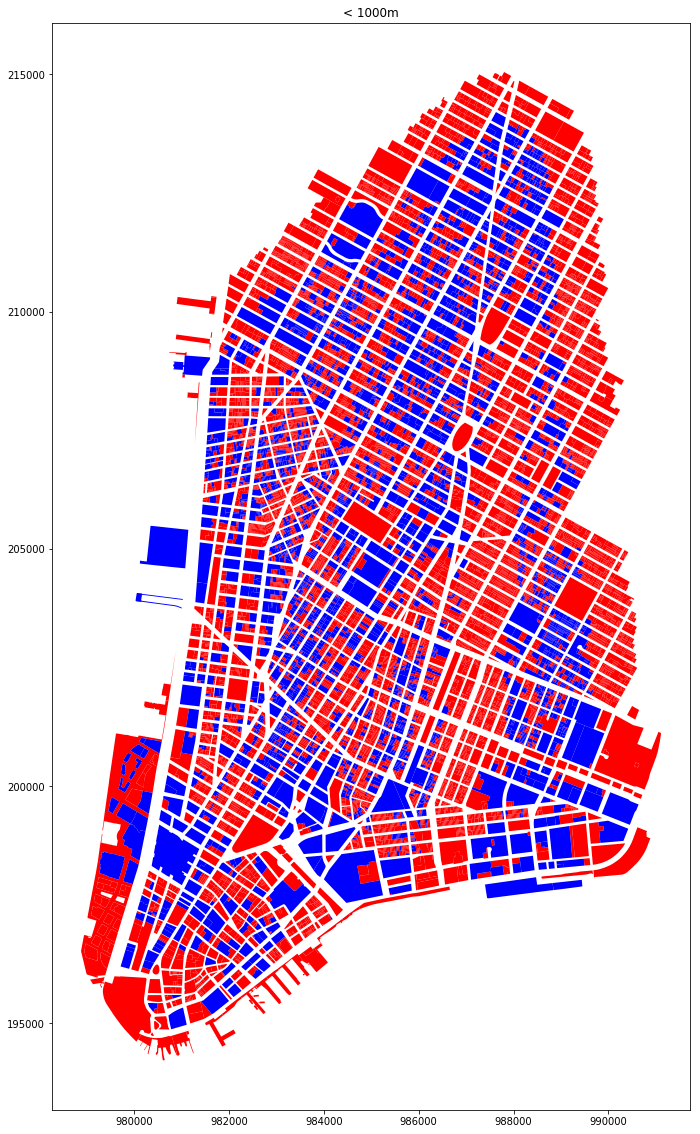

In [7]:
out_reset = out_frame.reset_index()
out_reset["dist"] = np.array(dists_arr)
ax = out_reset[out_reset["dist"] < 1000].plot(figsize=(16, 20), color='red')
in_frame.plot(color='blue', ax=ax)
ax.set_title("< 1000m")

Text(0.5,1,'< 500m')

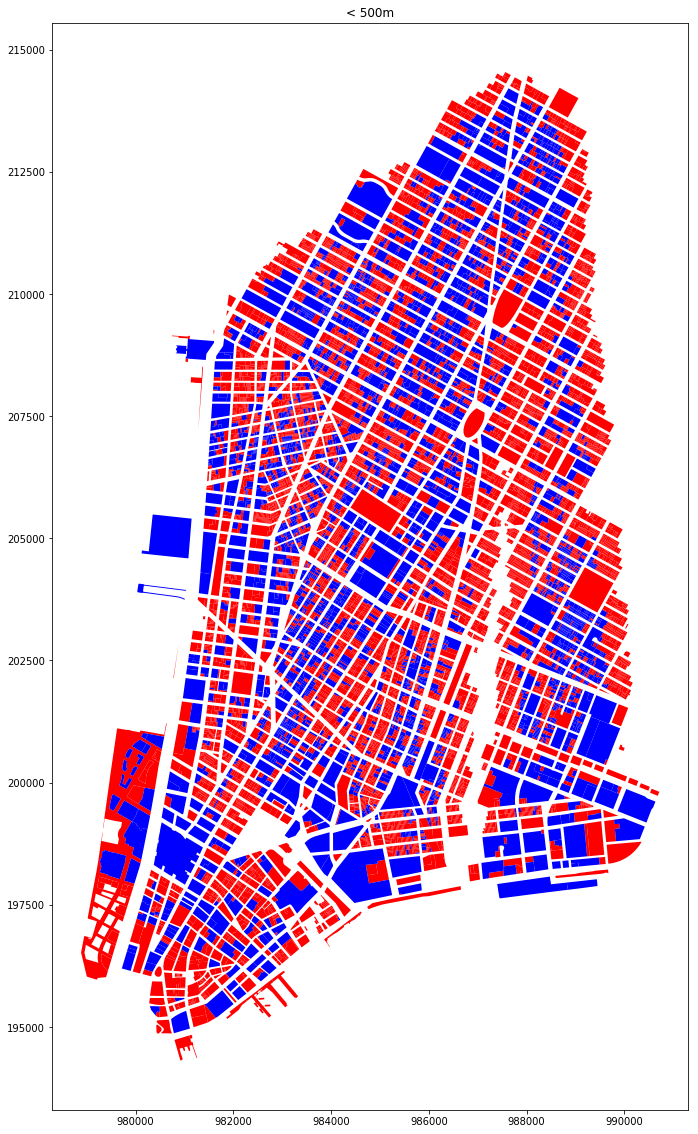

In [8]:
out_reset = out_frame.reset_index()
out_reset["dist"] = np.array(dists_arr)
ax = out_reset[out_reset["dist"] < 500].plot(figsize=(16, 20), color='red')
in_frame.plot(color='blue', ax=ax)
ax.set_title("< 500m")

## Incorporate light levels, 1 night

In [9]:
final_light_d6 = pd.read_csv("data/bbl_2017-09-28/2017-09-28_d6_10m.csv")
final_light_d9 = pd.read_csv("data/bbl_2017-09-28/2017-09-28_d9_10m.csv")
for df in (final_light_d6, final_light_d9):
    del df["Unnamed: 0"]
    del df["lat"]
    del df["lng"]
final_light_d6 = final_light_d6.set_index("BBL").swapaxes(1, 0)
final_light_d9 = final_light_d9.set_index("BBL").swapaxes(1, 0)

In [10]:
nearest_neighbors = [np.abs(in_frame.surface_area - osa).idxmin() for osa in out_frame.surface_area]
out_reset["nearest_ix"] = nearest_neighbors

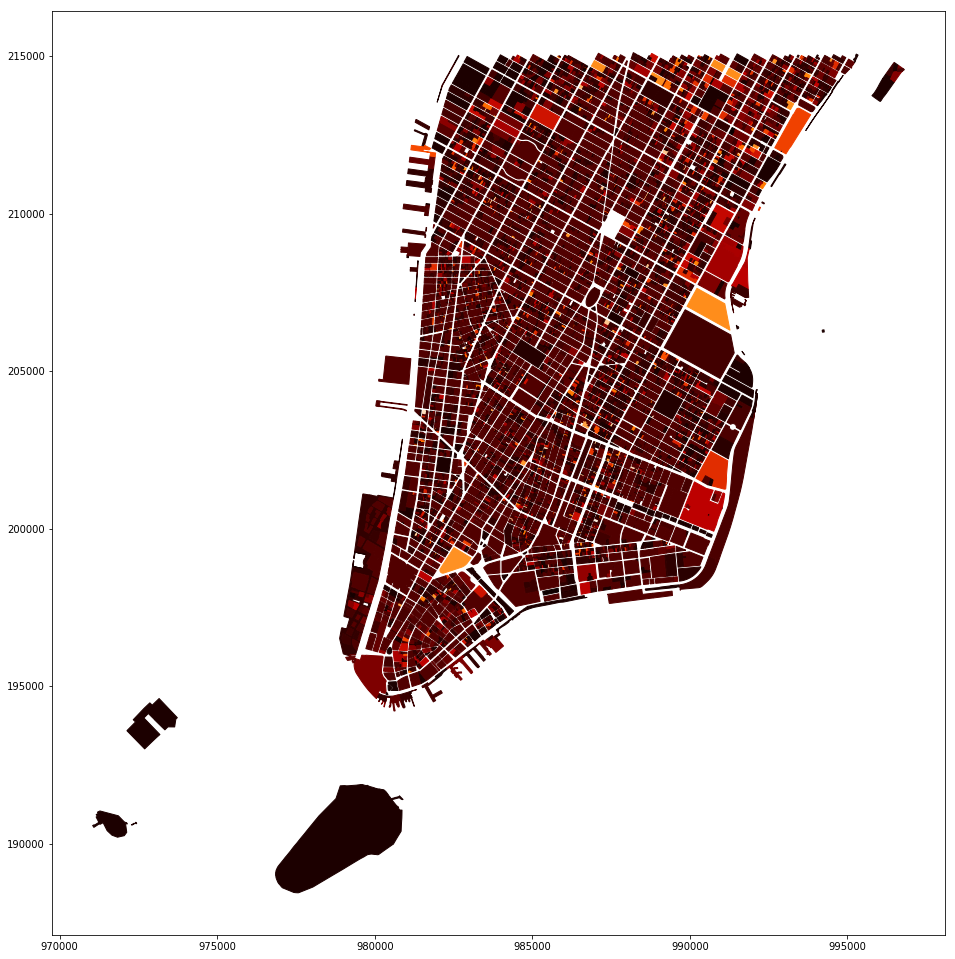

In [55]:

fig, ax = plt.subplots(1, 1, figsize=(16, 20))

polys = []
colors = []
scale = np.log10(final_light_d6.mean()).min()
for _, o_r in out_reset.iterrows():
    cbbl = in_frame.loc[o_r.nearest_ix].BBL
    c = final_light_d6[cbbl].mean() if cbbl in final_light_d6 else final_light_d9[cbbl].mean()
    polys.append(PolygonPatch(o_r.geometry))
    colors.append(plt.cm.gist_heat((np.log10(c) - scale)))
for _, i_r in in_frame.iterrows():
    polys.append(PolygonPatch(i_r.geometry))
    colors.append(plt.cm.gist_heat((np.log10(c) - scale)))

collection = PatchCollection(polys, color=colors)
ax.add_collection(collection)
ax.autoscale_view()
ax.set_aspect(1)

In [33]:
final_light_d6.max().max(), final_light_d9.max().max()

(1.0, 0.7111561889278477)

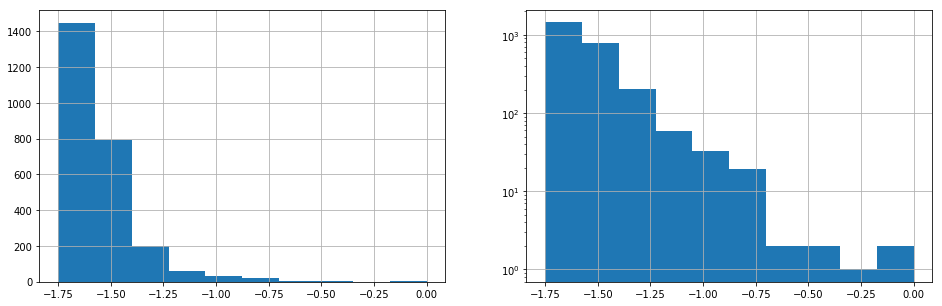

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
np.log10(final_light_d6.mean()).hist(log=True, ax=ax2)
np.log10(final_light_d6.mean()).hist(log=False, ax=ax1)

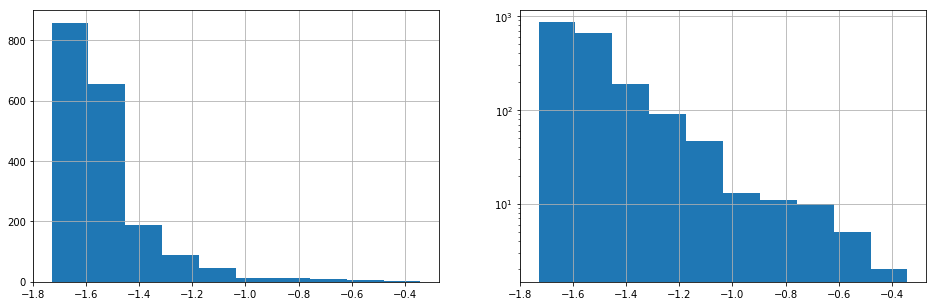

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
np.log10(final_light_d9.mean()).hist(log=True, ax=ax2)
np.log10(final_light_d9.mean()).hist(log=False, ax=ax1)

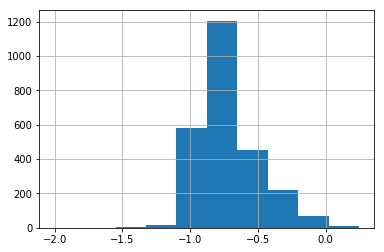

In [66]:
np.log10(np.log10(final_light_d6.mean()) - np.log10(final_light_d6.mean()).min() + .01).hist()

2436     824
33180     48
31789     44
40537     44
302       39
10844     38
28686     38
38611     36
195       36
6108      35
28520     34
11450     34
3167      33
22372     33
7818      33
39264     33
16688     32
40820     32
12662     32
34467     32
6015      31
17581     31
41389     30
22141     30
13161     29
24106     29
23724     29
8382      29
30098     28
8234      27
        ... 
12642      1
39271      1
18805      1
4470       1
10633      1
29066      1
26793      1
14321      1
15582      1
42213      1
9605       1
34286      1
28646      1
7661       1
3424       1
895        1
14339      1
20502      1
40984      1
10281      1
10297      1
11556      1
8312       1
24696      1
3352       1
33679      1
9461       1
31632      1
26785      1
10190      1
Name: nearest_ix, Length: 2657, dtype: int64

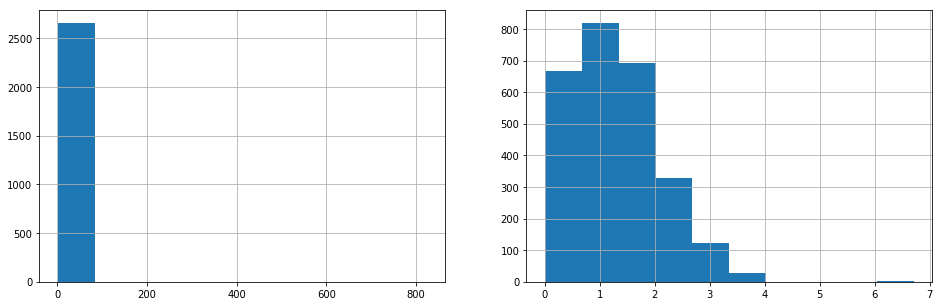

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
out_reset["nearest_ix"].value_counts().hist(ax=ax1)
np.log(out_reset["nearest_ix"].value_counts()).hist(ax=ax2)
out_reset["nearest_ix"].value_counts()